# Import Data

In [1]:
import os
train_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train')
test_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/test')

In [2]:
freshapples_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train/freshapples')
mediumfresh_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train/mediumfresh')
rottenapples_dir = os.path.join('C:/Users/User/Documents/DATASET FAHAD/train/rottenapples')


print('Total training fresh apples images:', len(os.listdir(freshapples_dir)))
print('\nTotal training medium fresh apple images:', len(os.listdir(mediumfresh_dir)))
print('\nTotal training rotten apples images:', len(os.listdir(rottenapples_dir)))

Total training fresh apples images: 1144

Total training medium fresh apple images: 1001

Total training rotten apples images: 1014


In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sb 
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras import Model


In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


# Data Preprocessing

In [5]:

# this is the augmentation configuration for training
TRAINING_DIR = "/content/train"
training_datagen = ImageDataGenerator(
        rescale = 1./255,                        #normalize
        rotation_range=40,                       #randomly rotated within the range of -40 degrees to 40 degrees
        width_shift_range=0.2,                   #Shift image
        height_shift_range=0.2,                   
        shear_range=0.2,                         #shear image
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')


# this is the augmentation configuration for testing:
# only rescaling
VALIDATION_DIR = "/content/test"
validation_datagen = ImageDataGenerator(rescale = 1./255) #normalize


# this is a generator that will read pictures found in subfolers of 'TRAINING_DIR', and indefinitely generate batches of augmented image data
train_generator = training_datagen.flow_from_directory(
    train_dir,                   # this is the target directory
    target_size=(224,224),          # all images will be resized to 224x224
    class_mode='categorical',       # since i use categorical_crossentropy loss, i need categorical labels
    batch_size= 100                  
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='categorical',
    batch_size= 50,
    shuffle=False
    
)

Found 3159 images belonging to 3 classes.
Found 1260 images belonging to 3 classes.


In [6]:
#get classes dict 
classes_dict = dict(validation_generator.class_indices)
#reverse 
classes_dict = {v: k for k,v in classes_dict.items()}

classes_dict


{0: 'freshapples', 1: 'mediumfresh', 2: 'rottenapples'}

# Build Model

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


pre_trained_model = InceptionV3(input_shape = (224, 224, 3),  #RGB Images with 224 x 224 pixels wide
                                include_top = False,          #excluded the FC layer at the top
                                weights = 'imagenet')         #the weights are pre-trained on ImageNet


'''
Since this model is very deep, the model used will be until the layer called mixed7
and all the weights up until this layer are fixed to speed up the training time.
'''
for layer in pre_trained_model.layers:
    layer.trainable = False

    

In [8]:

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

'''
From this layer (mixed7), the model will be flattened 
to be connected to a dense layer and then to the final dense output. 
All the weights after mixed7 are trainable.
'''


last layer output shape:  (None, 12, 12, 768)


'\nFrom this layer (mixed7), the model will be flattened \nto be connected to a dense layer and then to the final dense output. \nAll the weights after mixed7 are trainable.\n'

In [9]:

adam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)  #All default values


#FULLY CONNECTED LAYERS
x = layers.Flatten()(last_output)
#Dense hidden layer
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)   
#Output neuron               
x = layers.Dense (3, activation='softmax')(x)        

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = adam, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_5 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 25, 25, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 25, 25, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 25, 25, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 25, 25, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 25, 25, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 25, 25, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 25, 25, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 12, 12, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 12, 12, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 12, 12, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 12, 12, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 12, 12, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 12, 12, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 12, 12, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 12, 12, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 12, 12, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 12, 12, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 12, 12, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 12, 12, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

In [11]:
len(model.layers)

233

In [12]:
early = tf.keras.callbacks.EarlyStopping( patience=2,
                                          monitor='loss')
# early stopping call back
"""
By default, mode is set to ‘auto‘ to minimize loss or maximize accuracy.
Training will stop when the loss stops improving. 
"""

# Train Model

In [13]:
steps_per_epoch = 3159 // 100 #training set // batch size

validation_steps = 1260 // 50 #testing set // batch size

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 10,
            validation_steps = validation_steps,
            verbose = 1,
            callbacks=[early])

Epoch 1/10
31/31 [==============================] - 403s 12s/step - loss: 4.1622 - accuracy: 0.7028 - val_loss: 0.4783 - val_accuracy: 0.8808
Epoch 2/10
31/31 [==============================] - 401s 13s/step - loss: 0.3100 - accuracy: 0.8980 - val_loss: 0.1740 - val_accuracy: 0.9288
Epoch 3/10
31/31 [==============================] - 524s 17s/step - loss: 0.2050 - accuracy: 0.9248 - val_loss: 0.1120 - val_accuracy: 0.9616
Epoch 4/10
31/31 [==============================] - 399s 13s/step - loss: 0.1644 - accuracy: 0.9412 - val_loss: 0.1107 - val_accuracy: 0.9552
Epoch 5/10
31/31 [==============================] - 384s 12s/step - loss: 0.1495 - accuracy: 0.9457 - val_loss: 0.0853 - val_accuracy: 0.9680
Epoch 6/10
31/31 [==============================] - 351s 11s/step - loss: 0.1362 - accuracy: 0.9497 - val_loss: 0.1124 - val_accuracy: 0.9528
Epoch 7/10
31/31 [==============================] - 347s 11s/step - loss: 0.1377 - accuracy: 0.9519 - val_loss: 0.0906 - val_accuracy: 0.9632
Epoch 

# Save Model

In [14]:
tf.keras.models.save_model(model,'inceptionV3_model.hdf5')

# Accuracy Graph

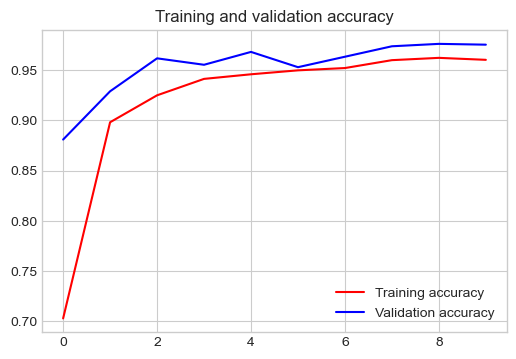

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.style.use('seaborn-whitegrid')
plt.figure(dpi = 100)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.show();

# Loss Graph

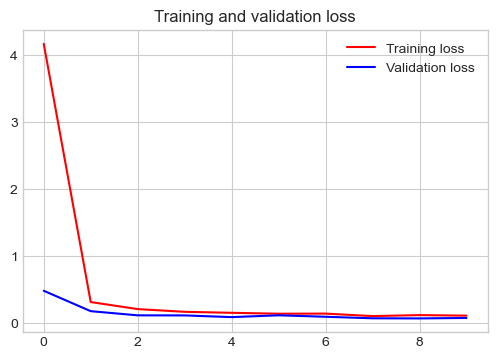

In [16]:
epochs = range(len(loss))

plt.style.use('seaborn-whitegrid')
plt.figure(dpi = 100)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show();

# Confusion Matrix

26/26 [==============================] - 110s 4s/step


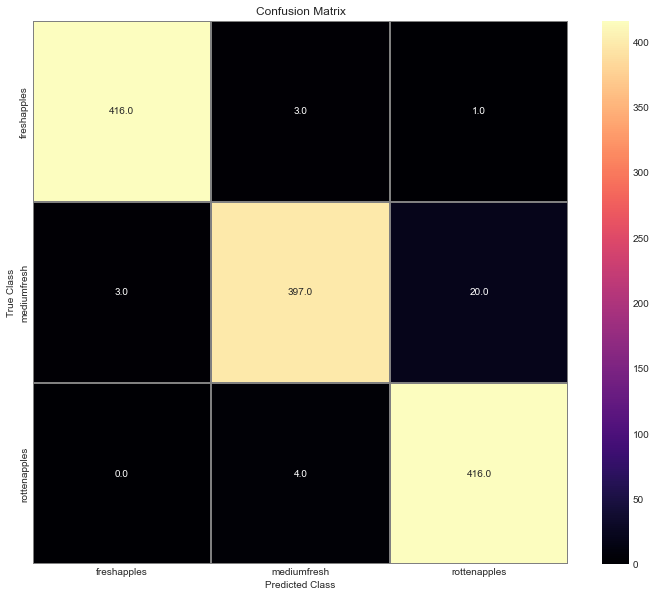

In [17]:
class_names = list(classes_dict.values())
labels = validation_generator.classes
preds =  model.predict(validation_generator)
predictions = np.argmax(preds, axis=1)
#show the confusion matrix 
conf_matrix = confusion_matrix(labels, predictions) 
# plot the confusion matrix
fig,ax = plt.subplots(figsize=(12, 10))
sb.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="magma",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
ax.set_xticklabels(labels = class_names,fontdict=None)
ax.set_yticklabels(labels = class_names,fontdict=None)
plt.show()

# Classification Report

In [18]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(validation_generator),axis=1)
print('Classification Report')
print(classification_report(labels, y_pred))

26/26 [==============================] - 123s 5s/step
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       420
           1       0.98      0.95      0.96       420
           2       0.95      0.99      0.97       420

    accuracy                           0.98      1260
   macro avg       0.98      0.98      0.98      1260
weighted avg       0.98      0.98      0.98      1260

